# Derive temperature field from wind field based on the thermal wind balance

original python script developed by Nicole Albern, KIT, 2022 was set up for a dry atmosphere

modifications by Christoph Braun, KIT, July 2023 to check the impact of using moist instead of dry atmosphere on the derived temperature field

## First some steps that can be done w/o distinction between dry and moist atmosphere

### import required libraries

In [1]:
import numpy as np
from netCDF4 import Dataset

import scipy.integrate

from numba import jit

import matplotlib.pyplot as plt

import netCDF4 as nc

### 1) load information of vertical levels

In [2]:
def load_levelinfo():
    
    fpath = '/work/bb1152/Module_A/A6_CyclEx/input_data/'
    file = Dataset(fpath+'ifs2icon_verticalgridinfo_137levels.nc', 'r')
    hyam = np.squeeze(np.array(file.variables['hyam']))
    hybm = np.squeeze(np.array(file.variables['hybm']))   
    hyai = np.squeeze(np.array(file.variables['hyai']))
    hybi = np.squeeze(np.array(file.variables['hybi']))   
    lev  = np.squeeze(np.array(file.variables['lev' ]))
    lev_2= np.squeeze(np.array(file.variables['lev_2']))    
    return hyam, hybm, hyai, hybi, lev, lev_2

In [3]:
hyam, hybm, hyai, hybi, lev, lev_2 = load_levelinfo()

### 2) define constants

physical constants are taken from

- Polvani and Esler, 2007
- Booth et al., 2013 Climate Dynamics
- or set to the values used in icon-nwp-2.0.15/src/shared/mo_physical_constants.f90

In [4]:
u0     = 45.0           # in m/s (as in Polvani and Esler, 2007)
zT     = 13.0e3         # in m (as in Polvani and Esler, 2007)
H      = 7.5e3          # in m (as in Polvani and Esler, 2007)
R      = 287.04         # dry gas constant in J/(kg K) (parameter rd in ICON)
a      = 6.371229e6     # average Earth radius in m (parameter earth_radius in ICON)
Omega  = 7.29212e-5     # angular velocity in 1/s (parameter earth_angular_velocity in ICON) 
T0     = 300            # in K (as in Polvani and Esler, 2007)
Gamma0 = -6.5e-3        # in K/m (as in Polvani and Esler, 2007)
alpha  = 10             # unitless (as in Polvani and Esler, 2007)
kappa  = 2.0/7.0        # unitless (as in Polvani and Esler, 2007)
g      = 9.80665        # av. gravitational acceleration in m/s2 (parameter grav in ICON)
p0     = 1.0e5          # globally-uniform surface pressure in Pa (as in Polvani and Esler, 2007)
# for relative humidity following Booth et al., 2013 Climate Dynamics
zTrh   = 12.0e3        
rh0    = 0.80           # relative humidity scaling factor from 0..1

### 3) define vertical grid

for computation of initial state we convert the ifs2icon hybrid levels to height levels assuming a globally-uniform surface pressure (defined above) and defining height according to Polvani and Elsner as z = H ln (p0/p)

In [5]:
p  = hyam + hybm*p0
z  = H*np.log(p0/p)  # np.log is natural logarithm
nz   = z.size

### 4) define latitude-longitude grid

In [6]:
lat  = np.linspace(-90, 90, 360)
lon  = np.linspace(0.0,360,10)
nlat = lat.size
nlon = lon.size

# latitude in radians
latrad = lat * np.pi/180.0

### 5) define wind field for lifecycle 1 (as in Polvani and Esler, 2007; eqns 6 and 7)

In [7]:
u1 = np.zeros((nz,nlat))+np.nan
F1  = np.power(np.sin(np.pi*np.power(np.sin(latrad),2)),3); F1[lat<0] = 0.0
for i in range(0, nz):
    for j in range(0, nlat):
        u1[i,j] = u0*F1[j]*(z[i]/zT)*np.exp(-0.5*(np.power(z[i]/zT,2)-1))

## Here we come to the step, where temperature and virtual temperature should be distinguished

we first follow the original script by Nicole Albern here

### 6) define latitude independent reference temperature profile (as in Polvani and Esler, 2007; eqn A5)

In [8]:
Tr = np.zeros((nz, nlat)) + np.nan
for i in range(0, nz):
    Tr[i, :] = T0 + Gamma0/np.power((np.power(zT,-alpha)+np.power(z[i],-alpha)),1/alpha)

### 7) compute temperature profile in zonal wind balance with wind field (as in Polvani and Esler, 2007; eqn A4)
#### 7A) define integrand from eqn A4

In [9]:
@jit
def Tintegrand(latrad, z, zT, U0, a, Omega):
    f  = 2*Omega*np.sin(np.deg2rad(45.0))
    F  = np.power(np.sin(np.pi*np.power(np.sin(latrad),2)),3)
    if latrad<0: F=0.0
    u1 = U0*F*(z/zT)*np.exp(-0.5*(np.power(z/zT,2)-1))
    du1dz = u1*(1/z-z/np.power(zT,2))
    return (a*f+2*u1*np.tan(latrad))*du1dz

#### 7B) integrate

In [10]:
tmp = np.zeros((nz, nlat)) + np.nan
for i in range(0, nz):
    for j in range(0, nlat):
        tmp[i, j] =scipy.integrate.quad(Tintegrand, 0, latrad[j], args=(z[i], zT, u0, a, Omega))[0]

#### 7C) add integrand into eqn A4

In [11]:
T=Tr-H/R*tmp

### 8) calculate potential temperature

In [12]:
theta=T*np.expand_dims(np.exp(kappa*z/H),axis=1)

### 9) define relative humidity profile

follows Booth et al. 2013, Climate Dynamics 

In [13]:
rh = np.zeros((nz, nlat)) + np.nan
for i in range(0, nz):
    if z[i]>14e3:
        rh[i, :] = 0.0
    else:
        rh[i, :] = rh0*np.power(1-0.85*z[i]/zTrh, 1.25)

### 10) calculate specific humidty

follows calculation in icon 

/icon-nwp-2.0.15/src/atm_phy_schemes/mo_satad.f90 -> sat_pres_water,spec_humi

In [14]:
b1 = 610.78  # --> c1es in mo_convect_tables.f90 
b2w= 17.269  # --> c3les 
b3 = 273.15  # --> tmelt; melting temperature in K
b4w= 35.86   # --> c4les
sat_pres_water = b1*np.exp(b2w*(T-b3)/(T-b4w))
Rdv = 287.04/461.51   # Rd/Rv; replace Rd by R as values are identical?
o_m_Rdv = 1-Rdv       # 1-Rd/Rv

qv = np.zeros((nz, nlat))
for i in range(0, nz):
    for j in range(0, nlat):
        qv[i, j] = rh[i,j]*Rdv*sat_pres_water[i,j]/(p[i]-o_m_Rdv*sat_pres_water[i,j]) # Do I understand this equation?

### Plotting results

In [15]:
def plot_zonfield(var,clabel,vmin=None,vmax=None,levels=None):
    
    fig = plt.figure()
    
    if (vmin or vmax or levels):
        levels = np.linspace(vmin,vmax,levels)
        cbar = plt.contourf(lat,z/1e3,var,levels=levels)
    else:
        cbar = plt.contourf(lat,z/1e3,var)
        
    plt.xlim(0,90)
    plt.ylim(0,50)
    plt.xlabel('latitude [°N]')
    plt.ylabel('height [km]')
    
    fig.colorbar(cbar,label=clabel)
    
    return

In [16]:
plot_zonfield(u1,'zonal wind [m/s]')

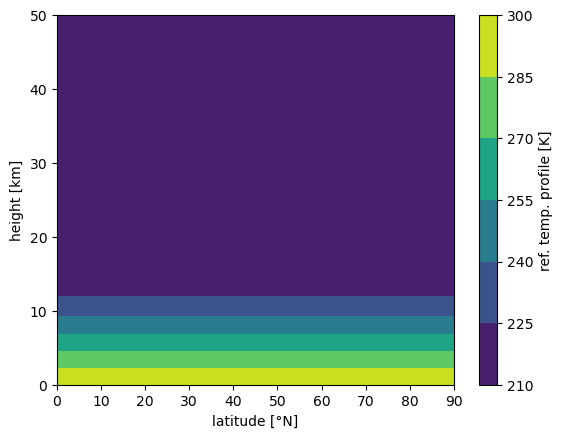

In [17]:
plot_zonfield(Tr,'ref. temp. profile [K]')

In [18]:
plot_zonfield(T,'T [K]')

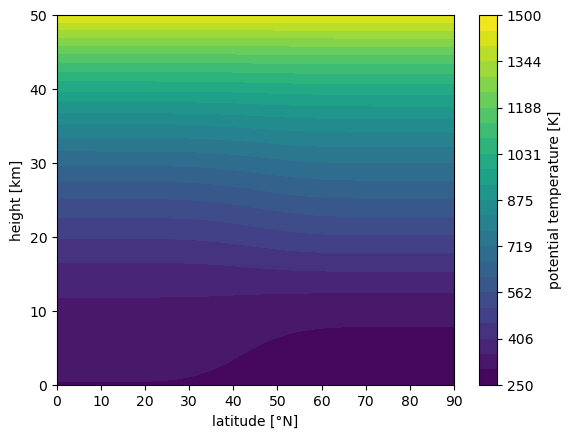

In [19]:
plot_zonfield(theta,'potential temperature [K]',vmin=250,vmax=1500,levels=25)

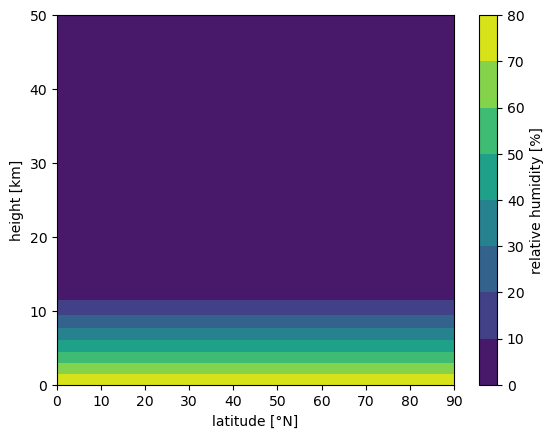

In [20]:
plot_zonfield(rh*100,'relative humidity [%]')

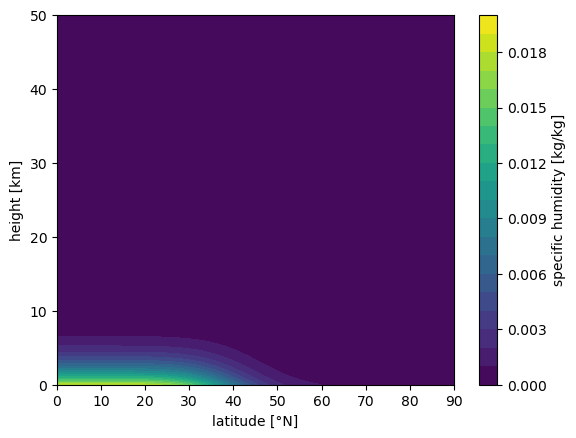

In [21]:
plot_zonfield(qv,'specific humidity [kg/kg]',vmin=0,vmax=0.02,levels=21)

## Now to the moist atmosphere...

To make it clear we redefine the functions from above

### 6) define latitude independent reference virtual temperature profile (similar to Polvani and Esler, 2007; eqn A5)

This implies a difference compared to above procedure

In [22]:
Tv0 = 300 # K, similar as above

In [23]:
Tvr = np.zeros((nz, nlat)) + np.nan
for i in range(0, nz):
    Tvr[i, :] = Tv0 + Gamma0/np.power((np.power(zT,-alpha)+np.power(z[i],-alpha)),1/alpha)

### 7) compute temperature profile in zonal wind balance with wind field (as in Polvani and Esler, 2007; eqn A4)
#### 7A) define integrand from eqn A4

In [24]:
@jit
def Tvintegrand(latrad, z, zT, U0, a, Omega):
    f  = 2*Omega*np.sin(np.deg2rad(45.0))
    F  = np.power(np.sin(np.pi*np.power(np.sin(latrad),2)),3)
    if latrad<0: F=0.0
    u1 = U0*F*(z/zT)*np.exp(-0.5*(np.power(z/zT,2)-1))
    du1dz = u1*(1/z-z/np.power(zT,2))
    return (a*f+2*u1*np.tan(latrad))*du1dz

#### 7B) integrate

In [25]:
tmpv = np.zeros((nz, nlat)) + np.nan
for i in range(0, nz):
    for j in range(0, nlat):
        tmpv[i, j] =scipy.integrate.quad(Tvintegrand, 0, latrad[j], args=(z[i], zT, u0, a, Omega))[0]

#### 7C) add integrand into eqn A4

In [26]:
Tv=Tvr-H/R*tmpv

### skip step 8) (calculate potential temperature) from above here and do it later

### use same rh profile as above. So no need to redefine it (see 9) define relative humidity profile)

### turn above calculation of qv (10) calculate specific humidty) into a 0D function qv(T,rh,p)

In [27]:
def get_qv_0D(T,rh,p):
    
    # define constants
    b1 = 610.78  # --> c1es in mo_convect_tables.f90 
    b2w= 17.269  # --> c3les 
    b3 = 273.15  # --> tmelt; melting temperature in K
    b4w= 35.86   # --> c4les

    Rdv = 287.04/461.51   # Rd/Rv; replace Rd by R as values are identical?
    o_m_Rdv = 1-Rdv       # 1-Rd/Rv
    
    sat_pres_water = b1*np.exp(b2w*(T-b3)/(T-b4w))

    qv = rh*Rdv*sat_pres_water/(p-o_m_Rdv*sat_pres_water) # Do I understand this equation?
            
    return qv

### 11) get Tmoist from Tv
#### 11A) define 1D nonlinear eq to be solved for Tmoist

In [28]:
def get_Tmoist(T,Tv,rh,p):
    qv = get_qv_0D(T,rh,p)
    return Tv/(1+0.61*qv) - T

#### 11B) solve nonlinear eq

use Tv as initial solution for Tmoist

In [29]:
from scipy.optimize import fsolve

In [30]:
Tmoist = np.zeros((nz, nlat)) + np.nan
for i in range(0, nz):
    for j in range(0, nlat):
        Tmoist[i,j] = fsolve(get_Tmoist, Tv[i,j], args = (Tv[i,j],rh[i,j],p[i]))

#### 11C) Check quality of results by seeing whether nonlinear equation is fulfilled

In [31]:
for i in range(0, nz):
    for j in range(0, nlat):
        if not np.isclose(get_Tmoist(Tmoist[i,j],Tv[i,j],rh[i,j],p[i]), 0):
            print('Not solved.')

### 12) calculate potential temperature

In [32]:
theta_moist=Tmoist*np.expand_dims(np.exp(kappa*z/H),axis=1)

### 13) calculate specific humidty (similar to dry procedure above but turned into a function)

In [33]:
def get_qv(T,rh,p,nz,nlat):
    
    # define constants
    b1 = 610.78  # --> c1es in mo_convect_tables.f90 
    b2w= 17.269  # --> c3les 
    b3 = 273.15  # --> tmelt; melting temperature in K
    b4w= 35.86   # --> c4les

    Rdv = 287.04/461.51   # Rd/Rv; replace Rd by R as values are identical?
    o_m_Rdv = 1-Rdv       # 1-Rd/Rv
    
    sat_pres_water = b1*np.exp(b2w*(T-b3)/(T-b4w))

    # initialize qv
    qv = np.zeros((nz, nlat))
    
    # calculate qv
    for i in range(0, nz):
        for j in range(0, nlat):
            qv[i, j] = rh[i,j]*Rdv*sat_pres_water[i,j]/(p[i]-o_m_Rdv*sat_pres_water[i,j]) # Do I understand this equation?
            
    return qv

In [34]:
qv_moist = get_qv(Tmoist,rh,p,nz,nlat)

### 14) Plotting results for dry atmosphere

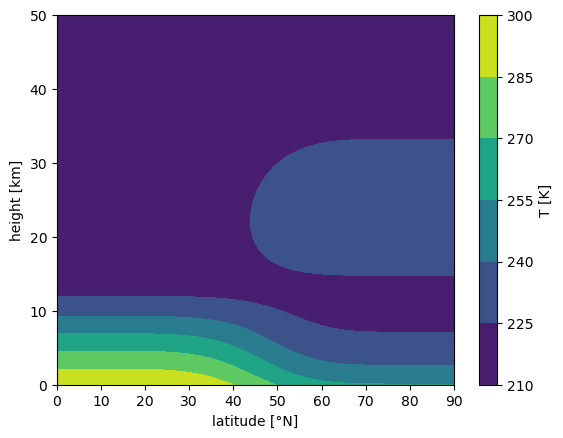

In [35]:
plot_zonfield(Tmoist,'T [K]')

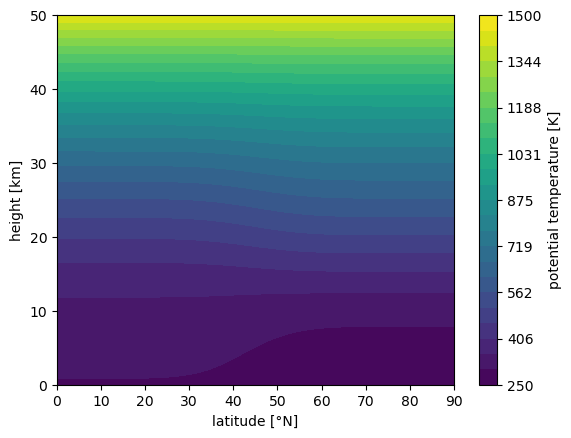

In [36]:
plot_zonfield(theta_moist,'potential temperature [K]',vmin=250,vmax=1500,levels=25)

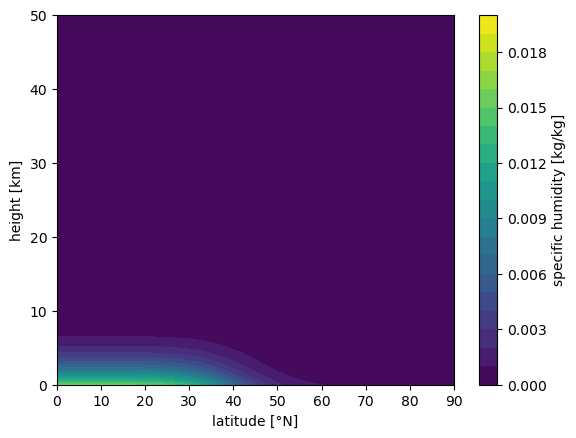

In [37]:
plot_zonfield(qv_moist,'specific humidity [kg/kg]',vmin=0,vmax=0.02,levels=21)

## Finally plotting differences between moist and dry atmosphere

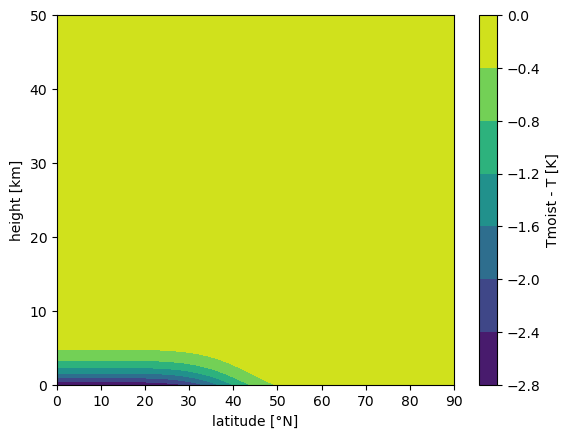

In [38]:
plot_zonfield((Tmoist-T),'Tmoist - T [K]')

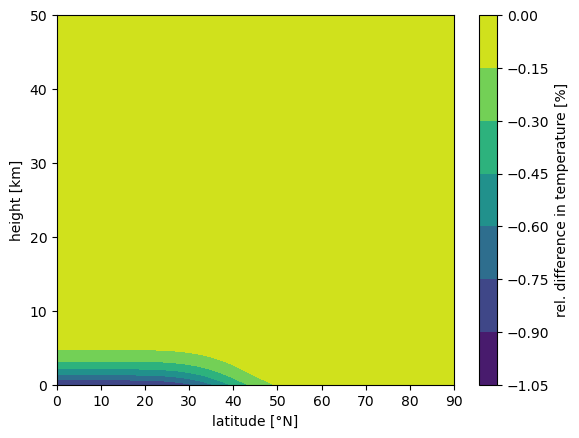

In [39]:
plot_zonfield((Tmoist-T)/T*100,'rel. difference in temperature [%]')

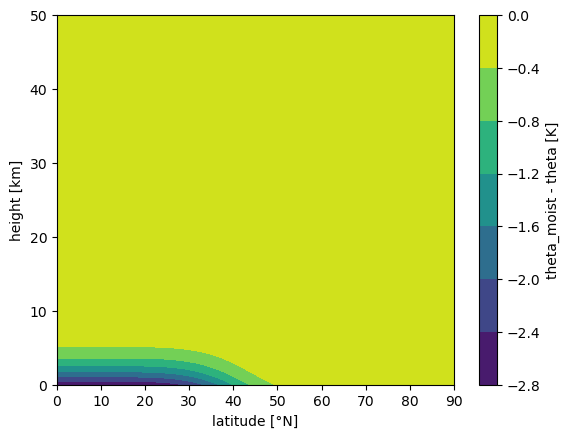

In [40]:
plot_zonfield((theta_moist-theta),'theta_moist - theta [K]')

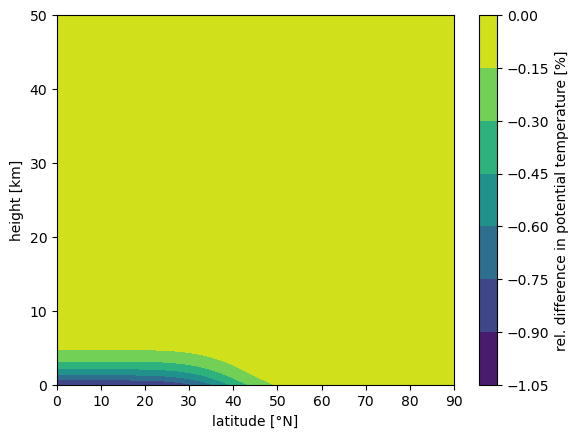

In [41]:
plot_zonfield((theta_moist-theta)/theta*100,'rel. difference in potential temperature [%]')

In [42]:
plot_zonfield((qv_moist-qv),'qv_moist-qv [kg/kg]')

/tmp/ipykernel_107218/2211109322.py:1: RuntimeWarning: invalid value encountered in divide
  plot_zonfield((qv_moist-qv)/qv*100,'rel. difference in specific humidity [%]')


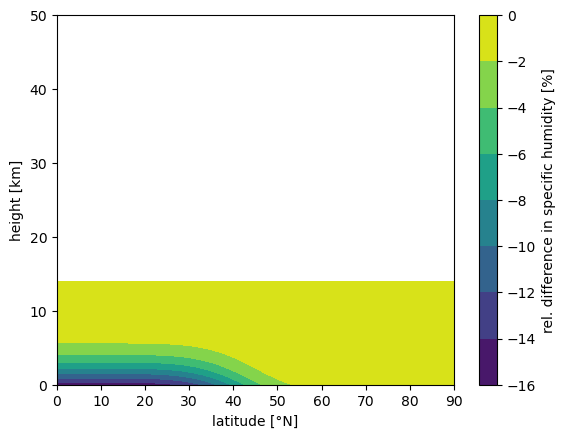

In [43]:
plot_zonfield((qv_moist-qv)/qv*100,'rel. difference in specific humidity [%]')

## Archive

In [44]:
# 2d function that did not work right away
def func(T,Tv,rh,p,nz,nlat):
    qv = get_qv(T,rh,p,nz,nlat)
    return Tv/(1+0.61*qv) - T